<a href="https://colab.research.google.com/github/ZeroLeon/NLP_Task_with_FastAI/blob/master/TextCls_TapTapComment_With_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Classification on TapTap Reviews with FAST.AI and BERT

##Background



**想法**：市场上手机游戏竞争非常激烈，手游收入是主流互联网公司比如腾讯网易的重要营收来源。这里想使用 fast.ai 框架结合 bert 预训练模型来实现一个手游用户口碑预测的功能

**数据来源**：TapTap，著名手游社区APP

**流程**： 使用爬取的评论数据做用户评价正负取向分类，将 fine-tune 后的语言模型应用在无标签的评论数据上（游戏论坛、贴吧、社区），观察模型评分得到用户口碑度。





##Preparation

In [0]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [0]:
#设置一个config类，便于参数配置与更改
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name='bert-base-chinese', 
    max_lr=3e-5,#The recommended lr is 3e-5 in bert paper, but 2e-5 is better in my tasks
    epochs=1,
    use_fp16=False, #fastai里可以方便地调整精度，加快训练速度：learner.to_fp16()
    bs=8,
    max_seq_len=256, #选取合适的seq_length，较大的值可能导致训练极慢报错等
    num_labels = 2 , # 0:negative, 1:positive
)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)
base_dir = '/content/gdrive/My Drive/fastai'
path = Path(base_dir +'/data/taptap_comment')
path.mkdir(parents=True,exist_ok=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install pytorch_pretrained_bert

##Dataset

共爬取 TapTap 上来源于三百多款游戏的玩家评论 5500 条，将字数过多或过少的评论剔除，清除缺失值以后还剩 4888 条。其中正向评价 2430 条（4星和5星），负向评价 2458 条（1、2、3星），数据集分布大致平衡。

在分类任务中这个数据集是较小的，我们看看之后模型的表现如何。

In [0]:
taptap_df = pd.read_csv(path/'taptap_review_ready.csv')

In [7]:
taptap_df.sample(10)

,review,sentiment
4467,画面黑插画风格黑就是暗黑了？？？玩了两个小时就删了游戏，原因如下：1，视角过低，可视范围小，...,0
821,_(: 」∠)_画风丑到描述不出来。。。自由度还是可以，npc对话给我整乐了，五星差评,1
2144,警告！据不完全统计，截止6月29日，此游戏下载人数约为270人，闯关失败的次数约为7000次...,1
2711,评论区一片差评吸引我进了游戏，画质差，没啥。但是当我点开一个智障的装备后给我弹出来一个广告？...,0
3656,游戏公司想赚钱可以理解，毕竟那么多开发宣传费用，手游玩了不少，基本玩一个月就删了，要不是太肝...,0
4320,现在就是有个问题就是，不知道大家有没有，我原来买的东西同步之后，在另外一个手机登录，然后那个...,0
1987,我刚下载游戏，特意看了评论，然后安装的时候竟然报毒！！！报毒！！我是真的有点害怕，所以先给3...,0
1393,本来想说给四星的但是想了想还是三星吧，毕竟三星炸了游戏本身来说像素风格还是挺符合一部分人的口...,0
2644,音乐给五分，体验给一分...很不忍心给三星但是思索再三还是残忍一点。因为这真的是少数几个我越...,0
15,tap推送就直接下载开始玩，从一进游戏就有浓重的暗黑3的影子，无论故事背景，画面，地图，角色...,0


In [11]:
label_representation = {1:'positive',0:'negative'}
taptap_df.sentiment.value_counts()

0    2458
1    2430
Name: sentiment, dtype: int64

##Using BERT with fast.ai

**在 fast.ai 框架下使用 bert 预训练模型需要注意几个要点：**



1.   Bert 有自己的 wordpiece tokenizer，在处理英文时会归类同一词根的不同词。
2.   Bert 使用特殊 token [CLS] 和 [SEP] 来区分 sequences，与 fast.ai 里的bos （begin of string）和 eos 有重合，所以在之后会有 include_eos=Fasle 的设置。
3.   Bert 有预置的 vocabulary，它的中文词库是字为单位建立的，所以百度的 ERNIE 模型在训练中引入了词的信息，效果有提升

In [13]:
#现在也可以直接从Pytorch Hub中引入
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

100%|██████████| 109540/109540 [00:00<00:00, 4198712.00B/s]


In [0]:
from pytorch_pretrained_bert import BertTokenizer
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
fastai_tokenizer = Tokenizer(
    tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), 
    pre_rules=[], 
    post_rules=[]
)

In [24]:
#check the vocab
list(bert_tok.vocab.items())[2100:2120]

[('存', 2100),
 ('孙', 2101),
 ('孚', 2102),
 ('孛', 2103),
 ('孜', 2104),
 ('孝', 2105),
 ('孟', 2106),
 ('孢', 2107),
 ('季', 2108),
 ('孤', 2109),
 ('学', 2110),
 ('孩', 2111),
 ('孪', 2112),
 ('孫', 2113),
 ('孬', 2114),
 ('孰', 2115),
 ('孱', 2116),
 ('孳', 2117),
 ('孵', 2118),
 ('學', 2119)]

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

##Setup Databunch

In [0]:
#分割训练集train与验证集valid,设定随机数种子确保结果复现
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(taptap_df,random_state=42)

In [0]:
#数据集较大的情况下，可以使用子集快速测试，本次数据集较小忽略这一步
if config.testing:
  train = train_df.head(1024)
  valid = valid_df.head(1024)
else:
  train = train_df
  valid = valid_df

In [29]:
print(train.shape)
print(valid.shape)

(3666, 2)
(1222, 2)


In [0]:
text_cols  = ['review']
label_cols = ['sentiment']

In [0]:
#建立 TextDataBunch
databunch = TextClasDataBunch.from_df(".", train, valid,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols= text_cols,
                  label_cols= label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [38]:
databunch.show_batch(8)

text,target
[CLS] 一 周 目 连 续 肝 了 三 天 ， 终 于 打 败 了 开 罗 姬 （ 开 罗 君 ∶ 开 罗 你 不 爱 我 了 ） 。 用 的 是 a 级 世 界 巨 星 级 选 手 ， 平 均 数 值 1800 左 右 。 游 戏 中 选 手 分 三 个 年 龄 段 ∶ 小 孩 ， 大,1
[CLS] 经 过 短 短 的 十 几 分 钟 ， 我 就 已 经 感 受 到 了 这 款 游 戏 满 满 的 恶 意 [UNK] 喵 的 这 也 太 难 了 点 吧 ！ ( ╯ [UNK] □ ′ ) ╯ [UNK] [UNK] 第 一 关 玩 了 十 几 次 都 没 有 过 ， 还 给 了 个 手 残 勋 章 ←,1
[CLS] 啊 啊 啊 啊 啊 啊 ， 兴 奋 到 不 行 ， 五 星 必 须 给 上 。 好 几 年 前 玩 电 脑 的 时 候 才 接 触 到 了 橙 光 ， 玩 了 很 多 文 字 游 戏 只 有 逆 袭 之 星 途 闪 耀 最 合 胃 口 玩 了 下 来 ， 主 打 言 楚 非,1
[CLS] 一 款 休 闲 向 小 游 戏 ， 玩 家 操 控 一 个 长 得 像 好 时 之 吻 巧 克 力 的 小 玩 意 ， 点 击 屏 幕 跳 跃 ， 阻 挡 玩 家 的 旋 转 圆 环 有 四 面 不 同 的 颜 色 ， 玩 家 需 要 根 据 自 身 颜 色 通 过 相 对,1
[CLS] ta ##p 游 戏 时 间 反 正 很 长 了 ， 我 欠 此 游 一 个 走 心 的 评 论 。 爱 丽 丝 加 一 星 。 美 人 鱼 加 一 星 。 睡 美 人 加 一 星 。 桃 乐 丝 加 一 星 。 小 天 鹅 加 一 星 。 然 后 黑 雪 加 ， 嗯 ？ 加 满,1
[CLS] 鉴 于 我 从 萌 新 玩 到 了 40 多 级 （ 并 且 心 态 好 了 ） 修 改 一 下 [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] 因 为 身 边 有 朋 友 在 玩 ， 我 就 入 坑 了 本 来 想 玩 国 际 服 ，,1
[CLS] 游 戏 运 行 蛮 流 畅 的 ， 毕 竟 测 试 服 ， 还 是 有 一 些 小 bug 的 。 下 载 好 一 打 开 的 时 候 ， 那 个 登 录 画 面 还 是 蛮 吸 引 人 的 。 游 戏 玩 法 比 较 多 ， 装 备 打 造 系 统 ， 玩 家 之 间 的 交,1
[CLS] 【 老 鸟 说 】 因 为 w ##x 跳 一 跳 而 被 推 上 风 口 浪 尖 的 一 个 游 戏 其 实 大 家 了 解 一 下 更 新 时 间 就 好 《 欢 乐 跳 瓶 》 最 近 的 一 次 更 新 时 间 为 2016 / 12 / 22 ##w ##x 跳 一 跳 出 现 时 间,1


In [42]:
databunch.one_item

<bound method DataBunch.one_item of TextClasDataBunch;

Train: LabelList (3666 items)
x: TextList
[CLS] 虽 然 掉 王 者 260 杯 了 但 实 力 偏 上 吧 我 想 发 表 几 个 观 点 不 喜 勿 喷 第 一 翠 竹 棒 特 点 是 铁 链 很 硬 但 是 一 块 石 头 一 下 子 就 能 砸 烂 两 根 而 且 15 跟 翠 竹 需 要 250 香 蕉 。 比 它 好 用 2 倍 的 * * * 才 200 香 蕉 好 吧 ， 前 期 解 锁 了 翠 竹 的 朋 友 相 信 跟 我 小 号 一 样 玩 不 走 了 第 二 钢 筋 版 这 么 说 吧 钢 筋 绳 子 比 翠 竹 的 铁 链 硬 板 子 比 合 金 版 强 今 天 有 幸 碰 到 过 一 个 用 钢 筋 版 的 玩 家 我 用 松 鼠 打 了 5 个 回 合 板 子 才 裂 一 点 小 缝 比 武 士 棍 实 用 3 倍 但 是 制 造 价 格 很 贵 ， 4000 香 蕉 15 根 贫 民 必 定 用 不 起 ， 所 以 匹 配 到 钢 筋 的 别 尝 试 割 绳 子 啃 板 子 了 直 接 退 游 重 来 吧 第 三 这 游 戏 现 在 我 一 天 玩 不 过 20 分 钟 了 香 蕉 不 够 用 用 低 级 板 子 跟 送 分 没 多 大 区 [SEP],[CLS] 调 戏 完 客 服 小 哥 哥 决 定 给 个 五 星 好 评 ( [UNK] • [UNK] • [UNK] ) [UNK] . 衔 接 不 太 好 ， 会 卡 ， 2 . 界 面 过 于 简 单 ， 可 以 丰 富 下 颜 色 ， 多 点 小 形 象 ， 3 . 熟 悉 的 游 戏 套 路 ， 只 不 过 又 有 了 一 个 叫 做 氧 气 瓶 的 东 西 ， 4 . 可 玩 性 有 待 提 高 ， 加 点 难 度 打 几 个 小 怪 是 个 好 套 路 ， 5 . 画 质 优 化 一 下 会 比 较 好 ， 颜 色 丰 富 一 些 ， 6 . 可 以 氪 金 提 高 装 备 ， 补 充 装 备 之 类 的 ， 7 . 声 优 很 简 单 的 ~ 有 点 傻 ， 希 望 有 更 多 的 人 物 形 象 ， 角 色 

In [0]:
databunch.save(path/'taptap_databunch.pkl')

##Model

In [43]:
bert_model = torch.hub.load('huggingface/pytorch-pretrained-BERT', 
                            'bertForSequenceClassification', 
                             config.bert_model_name, 
                             num_labels=config.num_labels)

Downloading: "https://github.com/huggingface/pytorch-pretrained-BERT/archive/master.zip" to /root/.cache/torch/hub/master.zip
100%|██████████| 382072689/382072689 [00:08<00:00, 43928159.77B/s]


In [46]:
#模型结构复杂，但不妨碍使用
bert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediat

In [0]:
#Loss function for multiclass problem
loss_func = nn.CrossEntropyLoss()

In [0]:
learner = Learner(
    databunch, 
    bert_model,
    loss_func=loss_func,
    metrics=[accuracy]
)

In [51]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


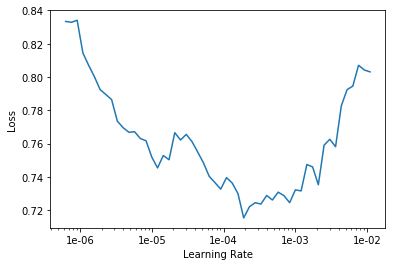

In [54]:
learner.recorder.plot(skip_end=20)

In [56]:
#开始训练
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.450950,0.432735,0.804419,05:55


Bert 官方论文里推荐的学习率是 3e-5，我们第一次训练使用了这个数值，得到准确率 80%。Jeremy 在 fast.ai 里推荐的学习率在最低点的左侧找，结合上图里的学习率曲线，我们在红圈附近微调一下学习率，看看结果如何


![尝试不同学习率](https://i.ibb.co/mcxGTpH/Snip20190626-10.png)

In [0]:
#我尝试了2e-5,训练了5个轮次，得到了更好的结果，训练时间较长，没有放在 presentation 里
learner.load(path/'stage_nice')

In [61]:
learner.fit_one_cycle(1, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.168973,0.153019,0.953355,05:31


##Interpretation

In [0]:
intepret = TextClassificationInterpretation.from_learner(learner)

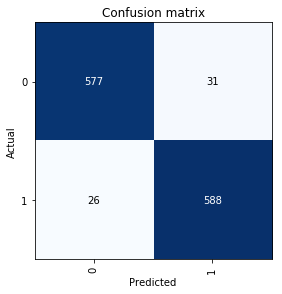

In [64]:
intepret.plot_confusion_matrix()

In [70]:
intepret.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
[CLS] 这 游 戏 成 功 让 我 了 解 到 了 什 么 是 真 正 的 脸 皮 厚 ， 名 子 叫 mc ， 进 去 一 看 ， 迷 你 世 界 ？ ， 全 人 机 不 说 ， 广 告 是 什 么 玩 意 啊 ！ 而 且 一 上 来 就 要 钱 ， 说 什 么 强 化 装 备 ？,0,0,5.18,0.99
[CLS] 我 都 不 好 意 思 打 分 我 手 机 是 oppo 好 吧 让 我 下 载 华 为 的 各 种 软 件 我 忍 了 下 载 了 那 么 久 各 种 乱 七 八 糟 的 东 西 更 新 也 忍 了 打 开 游 戏 那 个 广 告 就 在 正 中 央 不 大 不 小 刚 好 看,0,0,4.45,0.99
[CLS] 画 风 很 有 意 境 ， 有 国 风 的 感 觉 ， 音 乐 也 还 算 配 ， 只 是 和 评 论 里 说 的 一 样 过 关 时 候 一 声 y ##ea ##h 有 点 不 妥 。 但 这 都 不 是 大 毛 病 ， 游 戏 不 足 在 于 难 度 太 高 ， 不 用 叶 子,0,1,4.44,0.01
[CLS] 游 戏 体 验 并 不 是 那 么 良 好 ， 开 始 的 时 候 无 故 跳 转 到 乱 七 八 糟 的 小 程 序 ， 卡 顿 了 一 下 就 进 去 了 x 第 一 关 点 重 开 的 时 候 咔 地 闪 退 了 但 是 后 面 的 游 戏 还 是 蛮 顺 畅 的 ，,0,1,4.28,0.01
[CLS] 好 玩 ， 主 要 是 和 好 友 一 起 玩 挺 有 意 思 的 。 目 前 29 级 零 氪 ， 个 人 感 觉 骗 氪 并 不 严 重 ， 就 是 本 人 强 迫 症 有 点 烦 那 个 红 点 ， 不 氪 金 取 消 不 掉 。 希 望 能 更 丰 富 玩 法 和 技,0,1,3.97,0.02


In [0]:
test_f = pd.read_csv(path/'weibo_lajieer_test.csv')

In [82]:
test_f.comment.sample(5)

115    #拉结尔#游戏卡顿十分严重。我说的不是战斗过程。而是在城里就卡顿了，而且过场加载都很卡。明显...
133    2019年1月2日 星期三丨早报\n1.网易游戏发行的《风云岛行动》本周四全平台删档二测；\...
163    有一种陪伴叫斗鱼直播，我在主播阿飞的直播间等你，房间名：阿飞）晚上拉结尔商务线下，房间号：8...
78                 嗯？ 这个游戏？不就是_________吗\n#拉结尔##暗黑破坏神# ​
160    #卡泠#「卡丹兹我说过多少次了不要去挑衅戒之手们。难道你非让我把你谴送回去么？」泠呀手持拉结...
Name: comment, dtype: object

In [84]:
test_f.shape

(183, 3)

In [85]:
learner.predict('我出于好奇下载了疼讯的《拉结尔》……我没在意其他，只是发现旁白的声音越听越像掠风者的配音……')

(Category 0, tensor(0), tensor([0.6203, 0.3797]))

In [0]:
def test_pred(txt):
  pred = learner.predict(txt)
  if '1' in str(pred[0]):
    return 'Positive'
  else:
    return 'Negative'

In [0]:
test_f['predictions'] = test_f.comment.apply(test_pred)

In [91]:
test_f.predictions.head(5)

0    Positive
1    Negative
2    Negative
3    Negative
4    Negative
Name: predictions, dtype: object

In [97]:
test_f.predictions.value_counts()

Positive    118
Negative     65
Name: predictions, dtype: int64

In [0]:
ratings = test_f.predictions.value_counts()

In [104]:
#在10分的评分体系中的分数
rating_value = ratings.iloc[1]/ratings.iloc[0] 
rating_value*10

5.508474576271186

![拉结尔评分](https://i.ibb.co/R2T0x5y/Snip20190626-13.png)

In [106]:
#五星评分体系中的分数，与玩家社区的评分相近
rating_to_stars = rating_value*5
rating_to_stars

2.754237288135593

#Why is fast.ai so Awesome? 



**自上而下** => **快速上手** => **成果产生动力**



###通过短期学习就可以应用 BERT 这样业界先进模型对解决特定领域的问题产生助力。

###良好的架构方便学习者继续深入，可以进一步发掘深度学习的潜力，为自己的目标任务定制模型。

#Thanks to Anne!
